In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from branca.element import Element
from folium.plugins import HeatMap
from folium import LayerControl
import seaborn as sns


# Extract latitude and longitude from coordinates
def extract_lat_long_from_string(coord_str):
    try:
        coord_dict = eval(coord_str)
        return coord_dict.get('latitude'), coord_dict.get('longitude')
    except:
        return None, None

file_path = '/Users/gabrielerizzo/Downloads/1y DSM/Data-Driven/Big project DDI/Scraped_Data_Cleaned_Filtered.csv'

df = pd.read_csv(file_path, delimiter=';')

df.head()

,id,name,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,distance,neighborhood,borough
0,ywP0OEqRC6sp4NK1-QhW-g,Parm,False,https://www.yelp.com/biz/parm-new-york-4?adjus...,485,"['Italian', 'Sandwiches']",3.1,"{'latitude': 40.714473491420726, 'longitude': ...","['pickup', 'delivery']",Medium,"{'address1': '250 Vesey St', 'address2': '', '...",318.072.025.472.342,Battery Park City,Manhattan
1,WG639VkTjmK5dzydd1BBJA,Rubirosa,False,https://www.yelp.com/biz/rubirosa-new-york-2?a...,3436,"['Italian', 'Pizza']",4.3,"{'latitude': 40.722766, 'longitude': -73.996233}",['pickup'],Medium,"{'address1': '235 Mulberry St', 'address2': ''...",20.832.329.096.094.200,Battery Park City,Manhattan
2,pL2tig3FxJcrZ4wDIO4TsA,Eataly NYC Downtown,False,https://www.yelp.com/biz/eataly-nyc-downtown-n...,1359,"['Grocery', 'Italian', 'Cafes']",3.6,"{'latitude': 40.710206, 'longitude': -74.011823}","['pickup', 'delivery']",Medium,"{'address1': '101 Liberty St', 'address2': 'Fl...",40.294.566.979.224.600,Battery Park City,Manhattan
3,pk89jzL1RsE9U0thf_z6tw,Locanda Verde,False,https://www.yelp.com/biz/locanda-verde-new-yor...,1893,"['Italian', 'Cocktail Bars', 'Breakfast & Brun...",3.9,"{'latitude': 40.7198601300801, 'longitude': -7...","['pickup', 'delivery']",High,"{'address1': '377 Greenwich St', 'address2': '...",10.494.745.304.674.300,Battery Park City,Manhattan
4,OCTiJwvjoK81WoDwsTkFvA,Paesano of Mulberry Street,False,https://www.yelp.com/biz/paesano-of-mulberry-s...,1602,"['Italian', 'Salad', 'Seafood']",4.1,"{'latitude': 40.718554, 'longitude': -73.997447}","['pickup', 'restaurant_reservation', 'delivery']",Medium,"{'address1': '136 Mulberry St', 'address2': ''...",1.750.900.737.420.610,Battery Park City,Manhattan


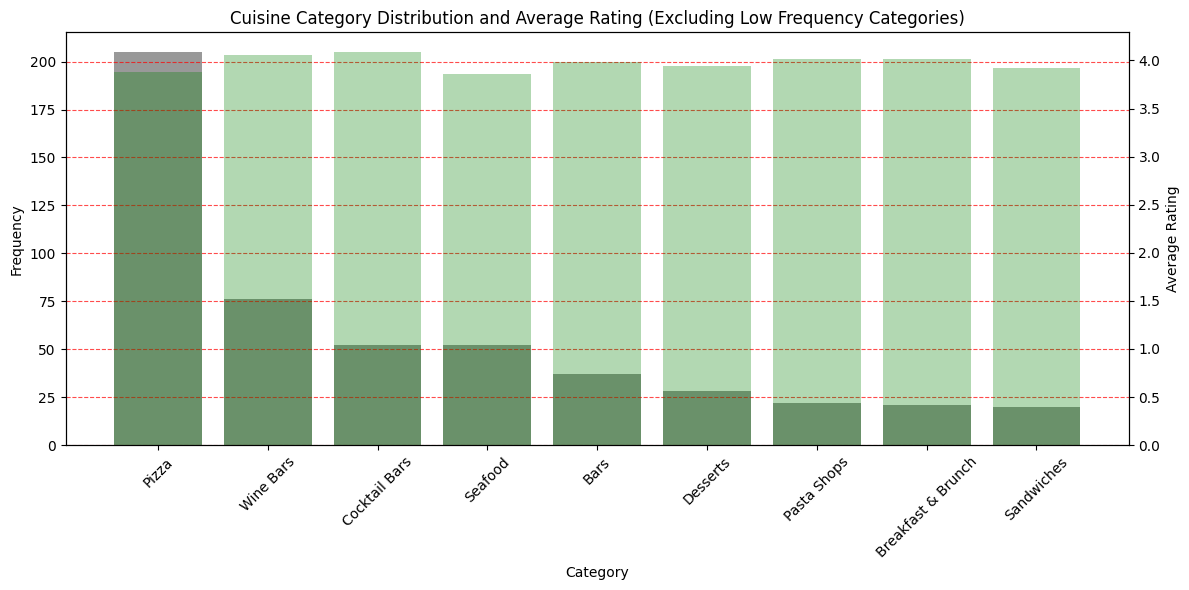

In [2]:
# Split the 'categories' column into individual categories and remove 'Italian'
categories_split = df['categories'].apply(lambda x: [cat for cat in eval(x) if cat != 'Italian'] if isinstance(x, str) else [])
all_categories = [category for sublist in categories_split for category in sublist]

# Calculate the frequency of each unique category
category_counts = pd.Series(all_categories).value_counts()

# Exclude categories with a frequency lower than 20
category_counts = category_counts[category_counts >= 20]

# Calculate the average rating for each category
ratings_split = df[['categories', 'rating']].dropna()
ratings_split['categories'] = ratings_split['categories'].apply(lambda x: [cat for cat in eval(x) if cat != 'Italian'] if isinstance(x, str) else [])
ratings_exploded = ratings_split.explode('categories')

# Filter out categories not in the category_counts
ratings_filtered = ratings_exploded[ratings_exploded['categories'].isin(category_counts.index)]

# Calculate the average rating for each category
avg_rating_per_category = ratings_filtered.groupby('categories')['rating'].mean()

# Plotting the bar chart for category distribution with secondary y-axis for average rating (using bar chart)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting category counts
ax1.bar(category_counts.index, category_counts.values, color='black', alpha=0.4, label='Frequency')
ax1.set_xlabel('Category')
ax1.set_ylabel('Frequency')
ax1.set_title('Cuisine Category Distribution and Average Rating (Excluding Low Frequency Categories)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', linestyle='--', alpha=0.7, color="red")

# Creating secondary y-axis for average rating
ax2 = ax1.twinx()

# Aligning the x values of the average rating with those of the categories
avg_rating_per_category = avg_rating_per_category.reindex(category_counts.index)

# Plotting the average rating as a bar chart on the secondary y-axis
ax2.bar(avg_rating_per_category.index, avg_rating_per_category.values, color='green', alpha=0.3, label='Average Rating')
ax2.set_ylabel('Average Rating')

plt.tight_layout()
plt.show()

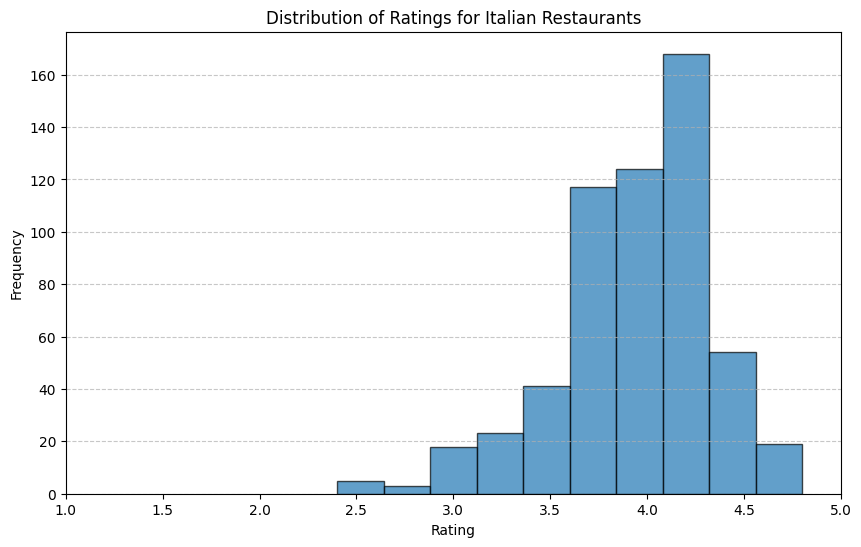

In [3]:
# Plotting the distribution of ratings with a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of Ratings for Italian Restaurants')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks([i * 0.5 for i in range(2, 11)])  # Setting ticks for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

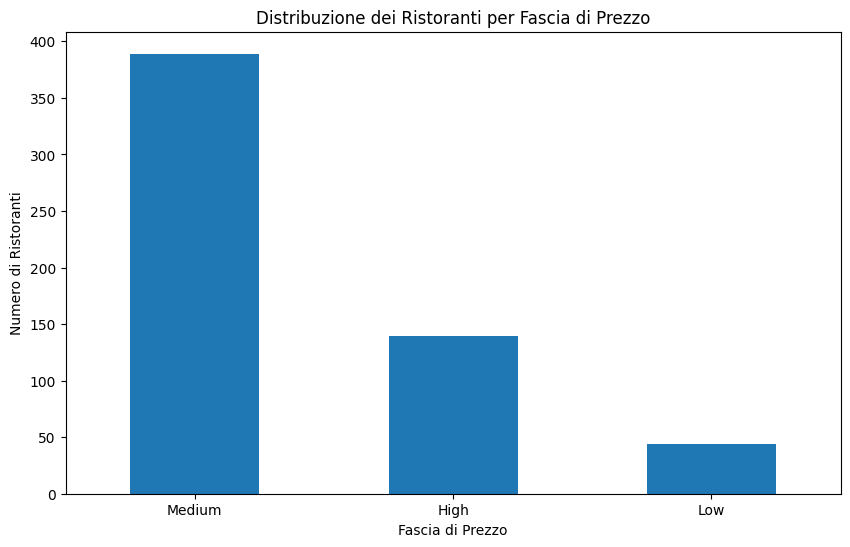

In [4]:
# Grafico a Barre della Fascia di Prezzo
# Count the number of occurrences of each price category
price_counts = df['price'].value_counts()

# Plotting the price distribution
plt.figure(figsize=(10, 6))
price_counts.plot(kind='bar')
plt.title("Distribuzione dei Ristoranti per Fascia di Prezzo")
plt.xlabel("Fascia di Prezzo")
plt.ylabel("Numero di Ristoranti")
plt.xticks(rotation=0)
plt.show()

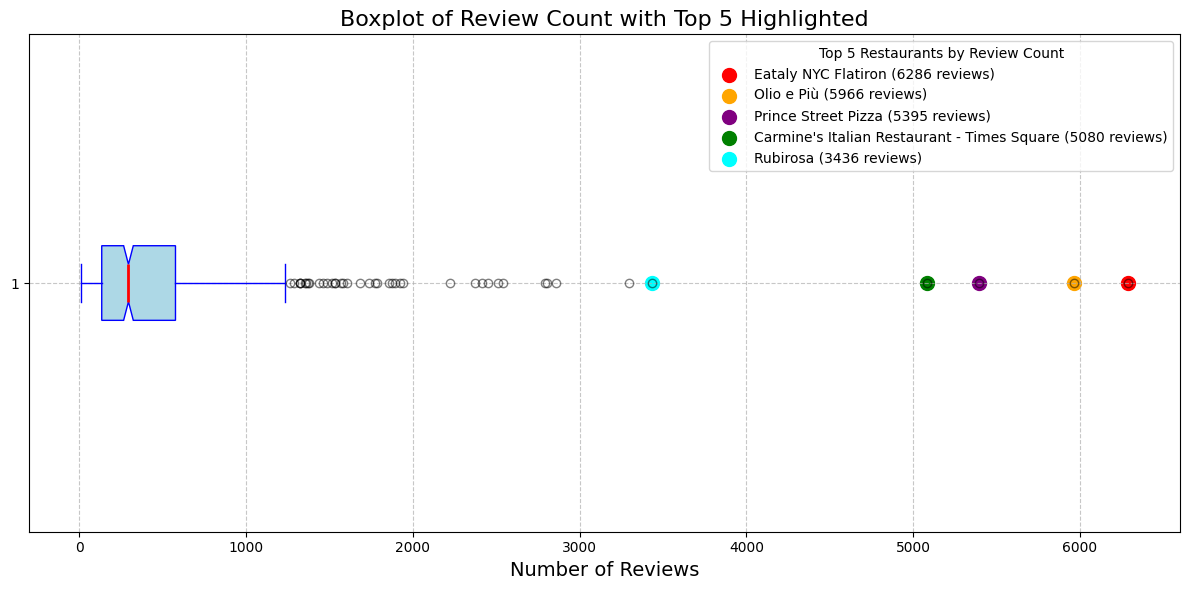

In [5]:
# Sort the data to find the top 5 highest review counts
top_5_indices = df['review_count'].nlargest(5).index
top_5_counts = df.loc[top_5_indices, 'review_count']
top_5_names = df.loc[top_5_indices, 'name']

# Define unique colors for the top 5 points
colors = ['red', 'orange', 'purple', 'green', 'cyan']

fig, ax = plt.subplots(figsize=(12, 6))

# Create the boxplot
ax.boxplot(df['review_count'], vert=False, patch_artist=True, notch=True,
           boxprops=dict(facecolor="lightblue", color="blue"),
           whiskerprops=dict(color="blue"),
           capprops=dict(color="blue"),
           medianprops=dict(color="red", linewidth=2),
           flierprops=dict(marker='o', color='blue', alpha=0.5))

# Add scatter points for the top 5 review counts with assigned colors
for i, (count, name, color) in enumerate(zip(top_5_counts, top_5_names, colors)):
    ax.scatter(count, 1, color=color, s=100, label=f"{name} ({count} reviews)")

# Customize plot labels and legend
ax.set_title('Boxplot of Review Count with Top 5 Highlighted', fontsize=16)
ax.set_xlabel('Number of Reviews', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(title="Top 5 Restaurants by Review Count", loc='upper right')

plt.tight_layout()
plt.show()

In [6]:
# Prepare the map again to ensure it's built with the new features
m = folium.Map(location=[40.7831, -73.9712], zoom_start=12)

# Title and description as HTML
title_html = '''
     <h3 align="center" style="font-size:16px"><b>Distribution of Italian Restaurants by Neighborhood in Manhattan</b></h3>
     <p align="center" style="font-size:12px">This map shows the concentration of Italian restaurants in various neighborhoods in Manhattan.<br>
     Each marker represents a restaurant, with details on rating and review count.<br> Areas with more markers indicate higher competition.</p>
     '''
m.get_root().html.add_child(Element(title_html))

# Adding a marker cluster to display individual restaurant locations
marker_cluster = MarkerCluster().add_to(m)

# Loop through the dataset to add restaurant markers
for idx, row in df.iterrows():
    try:
        coordinates = eval(row['coordinates'])
        lat, lon = coordinates['latitude'], coordinates['longitude']
        
        # Create a popup for each restaurant with its name, rating, reviews, and neighborhood
        popup_text = f"<b>{row['name']}</b><br>Rating: {row['rating']}<br>Reviews: {row['review_count']}<br>Neighborhood: {row['neighborhood']}"
        
        # Add each restaurant as a marker in the marker cluster
        folium.Marker(
            location=[lat, lon],
            popup=popup_text,
            tooltip=row['name']
        ).add_to(marker_cluster)
    except (KeyError, TypeError, SyntaxError):
        continue

# Save map to an HTML file for download
#output_path = '/Users/gabrielerizzo/Downloads/1y DSM/Data-Driven/Big project DDI/Italian_Restaurants_Map_Manhattan.html'
#m.save(output_path)

m

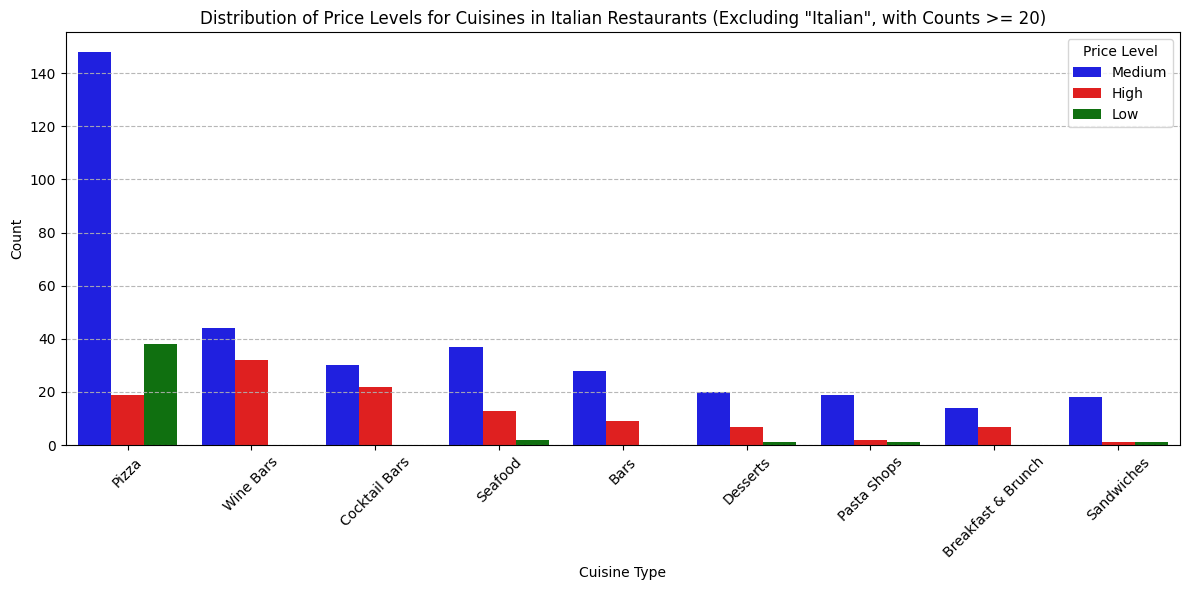

In [7]:
# Extracting necessary columns for analysis
price_df = df[['price', 'categories']].dropna()

# Clean up categories to create a more usable list of cuisines
def extract_cuisines(categories_str):
    try:
        return eval(categories_str)
    except:
        return []

price_df['cuisines'] = price_df['categories'].apply(extract_cuisines)

# Explode cuisines into separate rows
price_df_exploded = price_df.explode('cuisines')

# Filter out rows where the cuisine is just "Italian" to focus on other categories related to Italian restaurants
non_italian_related = price_df_exploded[~price_df_exploded['cuisines'].str.contains('Italian', case=False)]

# Filter out cuisines with fewer than 20 occurrences
cuisine_counts = non_italian_related['cuisines'].value_counts()
cuisines_above_20 = cuisine_counts[cuisine_counts >= 20].index

filtered_df = non_italian_related[non_italian_related['cuisines'].isin(cuisines_above_20)]

# Plotting the filtered distribution of price levels for other cuisines offered by Italian restaurants with custom colors
plt.figure(figsize=(12, 6))
palette = {'Low': 'green', 'Medium': 'blue', 'High': 'red'}
sns.countplot(data=filtered_df, x='cuisines', hue='price', order=filtered_df['cuisines'].value_counts().index, palette=palette)
plt.title('Distribution of Price Levels for Cuisines in Italian Restaurants (Excluding "Italian", with Counts >= 20)')
plt.xlabel('Cuisine Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Price Level')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.tight_layout()
plt.show()

In [8]:
# Extract necessary columns for mapping
df['latitude'] = df['coordinates'].apply(lambda x: eval(x).get('latitude') if pd.notna(x) else None)
df['longitude'] = df['coordinates'].apply(lambda x: eval(x).get('longitude') if pd.notna(x) else None)

# Filter out rows with missing latitude or longitude
restaurants_df = df[['name', 'latitude', 'longitude', 'rating', 'review_count']].dropna(subset=['latitude', 'longitude'])

# Convert 'rating' and 'review_count' to numeric
restaurants_df['rating'] = pd.to_numeric(restaurants_df['rating'], errors='coerce')
restaurants_df['review_count'] = pd.to_numeric(restaurants_df['review_count'], errors='coerce')

# Create a folium map centered around New York City
restaurant_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add points to the map representing each restaurant
for _, row in restaurants_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['review_count'] ** 0.3,  # Size of the marker based on the number of reviews
        color='',
        fill=True,
        fill_color='blue' if row['rating'] >= 4.0 else 'red',  # Color based on the rating
        fill_opacity=0.6,
        popup=f"{row['name']}<br>Rating: {row['rating']}<br>Reviews: {row['review_count']}"
    ).add_to(restaurant_map)

# Save map to HTML file to display
#map_file_path = "/mnt/data/restaurant_dispersion_map.html"
#restaurant_map.save(map_file_path)

restaurant_map

In [9]:
# Filter the dataset for Italian restaurants located in Manhattan
italian_restaurants = df[df['categories'].str.contains('Italian', case=False, na=False)]
manhattan_restaurants = italian_restaurants[italian_restaurants['borough'].str.contains('Manhattan', case=False, na=False)]

manhattan_restaurants[['latitude', 'longitude']] = manhattan_restaurants['coordinates'].apply(
    lambda x: pd.Series(extract_lat_long_from_string(x))
)

# Drop rows with missing coordinates
manhattan_restaurants = manhattan_restaurants.dropna(subset=['latitude', 'longitude'])

# Create a base map centered around Manhattan
manhattan_map = folium.Map(location=[40.7831, -73.9712], zoom_start=12)

# Prepare data for HeatMap
heat_data = [[row['latitude'], row['longitude']] for index, row in manhattan_restaurants.iterrows()]

# Add HeatMap to the base map
HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(manhattan_map)

# Save map to HTML file to display
#heatmap_file_path = "/mnt/data/manhattan_italian_restaurants_heatmap.html"
#manhattan_map.save(heatmap_file_path)

manhattan_map

In [10]:
# Extract necessary columns for analysis
heatmap_data = df[['rating', 'coordinates']].dropna()

# Extract latitude and longitude from coordinates
heatmap_data[['latitude', 'longitude']] = heatmap_data['coordinates'].apply(
    lambda x: pd.Series(extract_lat_long_from_string(x))
)

# Drop rows with missing coordinates
heatmap_data = heatmap_data.dropna(subset=['latitude', 'longitude', 'rating'])

# Prepare data for the heatmap (latitude, longitude, rating)
heatmap_list = heatmap_data[['latitude', 'longitude', 'rating']].values.tolist()

# Create a folium map centered around New York City
nyc_heatmap = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add the heatmap layer
HeatMap(heatmap_list, radius=15, blur=10, max_zoom=13).add_to(nyc_heatmap)

# Save the map to an HTML file
#heatmap_file_path = "/mnt/data/nyc_rating_heatmap.html"
#nyc_heatmap.save(heatmap_file_path)

nyc_heatmap

In [11]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Assuming df is already loaded with the relevant data

# Extract necessary columns for the analysis
service_data = df[['name', 'coordinates', 'transactions', 'neighborhood']].dropna()

# Clean up coordinates to extract latitude and longitude
service_data[['latitude', 'longitude']] = service_data['coordinates'].apply(lambda x: pd.Series(extract_lat_long_from_string(x)))

# Explode the transactions into separate rows
service_data['transactions_list'] = service_data['transactions'].apply(lambda x: eval(x) if isinstance(x, str) else [])
service_data_exploded = service_data.explode('transactions_list')

# Prepare data for HeatMap based on different types of services
pickup_data = service_data_exploded[service_data_exploded['transactions_list'] == 'pickup'][['latitude', 'longitude']].dropna().values.tolist()
delivery_data = service_data_exploded[service_data_exploded['transactions_list'] == 'delivery'][['latitude', 'longitude']].dropna().values.tolist()
reservation_data = service_data_exploded[service_data_exploded['transactions_list'] == 'restaurant_reservation'][['latitude', 'longitude']].dropna().values.tolist()

# Create a folium map centered around New York City
nyc_heat_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add HeatMap layers for each type of service
pickup_heatmap = HeatMap(pickup_data, name='Pickup Density', radius=10, gradient={0.4: 'blue', 0.6: 'cyan', 1: 'green'})
delivery_heatmap = HeatMap(delivery_data, name='Delivery Density', radius=10, gradient={0.4: 'green', 0.6: 'yellow', 1: 'red'})
reservation_heatmap = HeatMap(reservation_data, name='Reservation Density', radius=10, gradient={0.4: 'red', 0.6: 'orange', 1: 'purple'})

# Add each HeatMap layer to the map
pickup_heatmap.add_to(nyc_heat_map)
delivery_heatmap.add_to(nyc_heat_map)
reservation_heatmap.add_to(nyc_heat_map)

# Add layer control to allow toggling between HeatMaps
folium.LayerControl(collapsed=False).add_to(nyc_heat_map)

# Save map to HTML file to display
#heat_map_file_path = "/mnt/data/nyc_service_heat_map_with_control.html"
#nyc_heat_map.save(heat_map_file_path)
#print(f"Heatmap saved to: {heat_map_file_path}")

nyc_heat_map

In [12]:
# Extract necessary columns and clean data
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['price'] = df['price'].str.lower()  # Normalize price levels for easier categorization

# Group by neighborhood to calculate most common price level
price_avg_per_neighborhood = df.groupby('neighborhood')['price'].apply(lambda x: x.mode()[0]).reset_index()

# Load coordinates for each neighborhood from the original dataset
neighborhood_coordinates = df[['neighborhood', 'coordinates', 'name', 'rating']].drop_duplicates().reset_index(drop=True)

# Extract latitude and longitude from coordinates
neighborhood_coordinates[['latitude', 'longitude']] = neighborhood_coordinates['coordinates'].apply(
    lambda x: pd.Series(extract_lat_long_from_string(x))
)

# Merge the most common price level with the coordinates
price_map_data = pd.merge(price_avg_per_neighborhood, neighborhood_coordinates, on='neighborhood')
price_map_data = price_map_data.dropna(subset=['latitude', 'longitude'])

# Create a folium map centered around New York City
price_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Create heat map layer for price levels (numeric representation for visualization)
price_numeric_mapping = {'low': 1, 'medium': 2, 'high': 3}
price_map_data['price_numeric'] = price_map_data['price'].map(price_numeric_mapping)
heat_data = [
    [row['latitude'], row['longitude'], row['price_numeric']] for index, row in price_map_data.iterrows()
]
HeatMap(heat_data, name='Price Heatmap', max_zoom=15, radius=20).add_to(price_map)

# Add separate layers for low, medium, and high price levels
low_price_data = price_map_data[price_map_data['price'] == 'low']
medium_price_data = price_map_data[price_map_data['price'] == 'medium']
high_price_data = price_map_data[price_map_data['price'] == 'high']

# Layer for low price
low_price_layer = folium.FeatureGroup(name='Low Price', show=False)
for _, row in low_price_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.6,
        tooltip=(
            f"Neighborhood: {row['neighborhood']}<br>"
            f"Name: {row['name']}<br>"
            f"Rating: {row['rating']}<br>"
            f"Price Level: Low"
        )
    ).add_to(low_price_layer)
low_price_layer.add_to(price_map)

# Layer for medium price
medium_price_layer = folium.FeatureGroup(name='Medium Price', show=False)
for _, row in medium_price_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        tooltip=(
            f"Neighborhood: {row['neighborhood']}<br>"
            f"Name: {row['name']}<br>"
            f"Rating: {row['rating']}<br>"
            f"Price Level: Medium"
        )
    ).add_to(medium_price_layer)
medium_price_layer.add_to(price_map)

# Layer for high price
high_price_layer = folium.FeatureGroup(name='High Price', show=False)
for _, row in high_price_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        tooltip=(
            f"Neighborhood: {row['neighborhood']}<br>"
            f"Name: {row['name']}<br>"
            f"Rating: {row['rating']}<br>"
            f"Price Level: High"
        )
    ).add_to(high_price_layer)
high_price_layer.add_to(price_map)

# Add a layer control to toggle between heatmap and price layers
LayerControl().add_to(price_map)

# Display the map
price_map